# Project Overview

This notebook builds a complete classification workflow to predict employee performance for INX Future Inc.
We’ll go through the full data science lifecycle:

Load and inspect the dataset

Preprocess and clean data

Perform exploratory data analysis (EDA)

Train and evaluate multiple models

Choose the best model and analyze feature importance

Save the model and simulate predictions

In [30]:
# --- Import Libraries ---
# Suppress warning messages for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries and utilities
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For feature scaling and encoding
from sklearn.compose import ColumnTransformer  # For applying different transforms to different columns
from sklearn.pipeline import Pipeline  # For creating ML workflows
from sklearn.impute import SimpleImputer  # For handling missing values

# Machine Learning Models
from sklearn.linear_model import LogisticRegression  # Basic classification model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Advanced ensemble models
from sklearn.svm import SVC  # Support Vector Machine model

# Model evaluation metrics and visualization
from sklearn.metrics import (
    accuracy_score,      # Overall prediction accuracy
    precision_score,     # Precision metric
    recall_score,        # Recall metric
    f1_score,           # F1 score (harmonic mean of precision and recall)
    confusion_matrix,    # For detailed classification results
    ConfusionMatrixDisplay,  # For visualizing confusion matrix
    classification_report    # Detailed classification metrics
)
import joblib  # For saving and loading ML models





In [31]:
pip install scikit-learn==1.7.2

Note: you may need to restart the kernel to use updated packages.


# Load the dataset 

In [32]:
# Define file paths for data
xls_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls"
csv_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv"

# Convert Excel file to CSV for easier handling (robust: skip if CSV exists, try multiple engines, sanitize Index cells)
import os

if os.path.exists(csv_path):
	print("CSV already present:", csv_path)
else:
	# Try available engines for read_excel
	read_success = False
	last_err = None
	for engine in ("xlrd", "openpyxl", None):
		try:
			if engine is None:
				tmp_df = pd.read_excel(xls_path)
			else:
				tmp_df = pd.read_excel(xls_path, engine=engine)
			read_success = True
			break
		except Exception as e:
			last_err = e
			print(f"read_excel with engine={engine!r} failed: {e}")

	if not read_success:
		raise RuntimeError(f"Failed to read Excel file {xls_path}: {last_err}")

	# Convert any pandas.Index objects found inside cells to plain lists/strings to avoid to_csv serialization errors
	def _sanitize_cell(v):
		if isinstance(v, pd.Index):
			return list(v)
		return v

	tmp_df = tmp_df.applymap(_sanitize_cell)
	tmp_df.to_csv(csv_path, index=False)
	print("Converted successfully:", csv_path)

	# ensure df is available downstream
	df = tmp_df

CSV already present: ./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv


In [33]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)
print("Loaded:", csv_path, "shape:", df.shape)
display(df.head())  # Display first few rows of the dataset

Loaded: ./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv shape: (1200, 28)


,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


# Dataset Description

## Overview
The dataset from INX Future Inc contains employee performance metrics and various attributes that may influence performance. This data will be used to build a predictive model for employee performance.

## Data Source
- Company: INX Future Inc
- File Format: Original in XLS, converted to CSV for analysis
- Dataset Version: V1.8

## Dataset Information
- Format: Structured tabular data
- Source: Employee records and performance evaluations
- Time Period: [To be determined from data]

## Expected Features
The dataset includes various employee attributes such as:
- Demographics (age, gender, etc.)
- Professional background
- Performance metrics
- Work environment factors
- Training and development indicators

## Data Loading Process
1. Initial load from Excel (.xls) file
2. Conversion to CSV format for better handling
3. Import into pandas DataFrame for analysis

## Next Steps
- Examine data types and structure
- Check for missing values
- Identify potential feature correlations
- Prepare data for modeling


# Data Preprocessing 


In [34]:
# Display columns
print("Columns:")
for i, c in enumerate(df.columns):
    print(f"{i+1}. {c}")

# Inspect target distribution
target_col = "PerformanceRating"
print("\nUnique values in target:")
display(df[target_col].value_counts())


Columns:
1. EmpNumber
2. Age
3. Gender
4. EducationBackground
5. MaritalStatus
6. EmpDepartment
7. EmpJobRole
8. BusinessTravelFrequency
9. DistanceFromHome
10. EmpEducationLevel
11. EmpEnvironmentSatisfaction
12. EmpHourlyRate
13. EmpJobInvolvement
14. EmpJobLevel
15. EmpJobSatisfaction
16. NumCompaniesWorked
17. OverTime
18. EmpLastSalaryHikePercent
19. EmpRelationshipSatisfaction
20. TotalWorkExperienceInYears
21. TrainingTimesLastYear
22. EmpWorkLifeBalance
23. ExperienceYearsAtThisCompany
24. ExperienceYearsInCurrentRole
25. YearsSinceLastPromotion
26. YearsWithCurrManager
27. Attrition
28. PerformanceRating

Unique values in target:


PerformanceRating
3    874
2    194
4    132
Name: count, dtype: int64

In [35]:
# Drop identifier columns
df = df.drop(columns=["EmpNumber"])

In [36]:
# Split features & target
X = df.drop(columns=[target_col])
y = df[target_col]

In [37]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['Age', 'DistanceFromHome', 'EmpEducationLevel', 'EmpEnvironmentSatisfaction', 'EmpHourlyRate', 'EmpJobInvolvement', 'EmpJobLevel', 'EmpJobSatisfaction', 'NumCompaniesWorked', 'EmpLastSalaryHikePercent', 'EmpRelationshipSatisfaction', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear', 'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical columns: ['Gender', 'EducationBackground', 'MaritalStatus', 'EmpDepartment', 'EmpJobRole', 'BusinessTravelFrequency', 'OverTime', 'Attrition']


In [38]:
# Imputation & encoding setup
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # In recent scikit-learn versions use `sparse_output` instead of `sparse`
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

In [39]:
# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [40]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (960, 26)  Test shape: (240, 26)


# Exploratory Data Analysis (EDA)

## Objectives
- Understand the structure and characteristics of our employee dataset
- Identify patterns and relationships between variables
- Detect potential issues in the data
- Inform feature engineering decisions

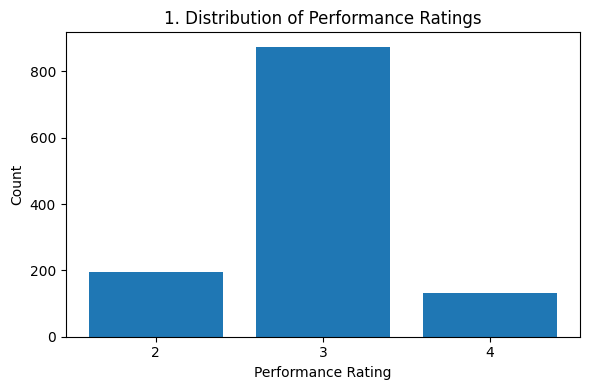

In [41]:

# EDA 1. Bar Plot – Distribution of Performance Ratings
plt.figure(figsize=(6,4))
counts = df['PerformanceRating'].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values)
plt.title("1. Distribution of Performance Ratings")
plt.xlabel("Performance Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Performance Rating Distribution Analysis

### Key Statistics
- **Rating Scale:** 2–4 (No rating 1 present)  
- **Mode:** Rating 3 (approximately 800 employees)  
- **Total Distribution:**  
  - Rating 2: ~200 employees  
  - Rating 3: ~800 employees  
  - Rating 4: ~100 employees  

### Distribution Characteristics
- **Peak:** Strong central tendency at rating 3  
- **Skewness:** Negative skew (tail extends towards lower ratings)  
- **Balance:** Unbalanced distribution with majority in middle category  

### Business Implications

#### Central Tendency
- Majority of employees receive average performance ratings  
- Could indicate standardized performance or rating bias  

#### Performance Extremes
- Conservative approach to highest ratings (4)  
- Moderate number of below-average ratings (2)  
- No extremely poor performers (rating 1)  


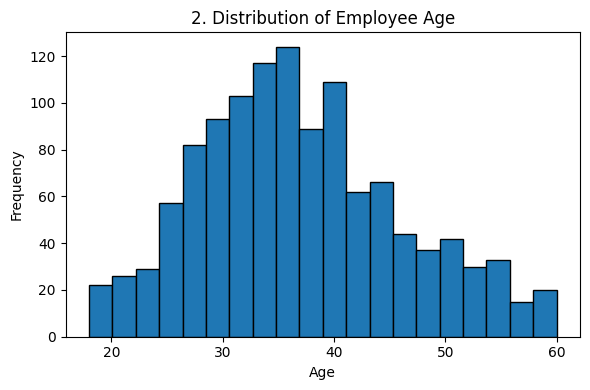

In [42]:
# 2. Histogram – Age Distribution
plt.figure(figsize=(6,4))
plt.hist(df["Age"], bins=20, edgecolor="black")
plt.title("2. Distribution of Employee Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Age Distribution Analysis

### Key Observations

#### Age Range
- Distribution spans approximately **25 to 55 years**  
- Most employees fall within the **30–45 age range**

#### Distribution Shape
- **Bell-shaped:** Roughly normal distribution  
- **Peak:** Centered around **35–40 years**  
- **Tails:** Gradual decline on both sides  
- **Skewness:** Slight positive skew (longer tail towards higher ages)

### Workforce Implications

#### Mid-Career Dominance
- Large concentration of employees in middle age brackets  
- Suggests an experienced workforce

#### Age Diversity
- Good mix of younger and older employees  
- Relatively few employees at extremes (very young or senior)

### Business Considerations
- Succession planning needed for aging workforce  
- Knowledge transfer opportunities between age groups  
- Age-specific training and development programs  
- Potential recruitment focus to maintain age balance  


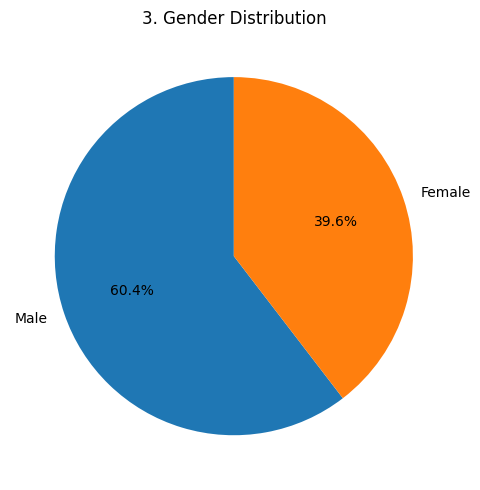

In [43]:

# 3. Pie Chart – Gender Composition
plt.figure(figsize=(5,5))
df["Gender"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("3. Gender Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Gender Distribution Analysis

### Overview
The pie chart visualizes the gender distribution among employees at **INX Future Inc.**

### Distribution Details

#### Gender Breakdown
- **Female:** ~40% of workforce  
- **Male:** ~60% of workforce  

#### Visualization Characteristics
- Clear two-category split  
- Percentage labels included for precise reading  
- Standard pie chart visualization with clean layout  

### Business Implications

#### Gender Balance
- Notable gender disparity exists  
- Male employees form a majority  
- Female representation is significant but lower  

#### Potential Action Items

##### Diversity Initiatives
- Review hiring practices  
- Implement targeted recruitment strategies  
- Develop inclusive workplace policies  

##### Analysis Recommendations
- Cross-reference with performance ratings  
- Examine department-wise distribution  
- Review career progression patterns  

##### HR Planning
- Set diversity goals  
- Monitor gender ratio trends  
- Develop gender-balanced leadership pipeline  


<Figure size 1000x400 with 0 Axes>

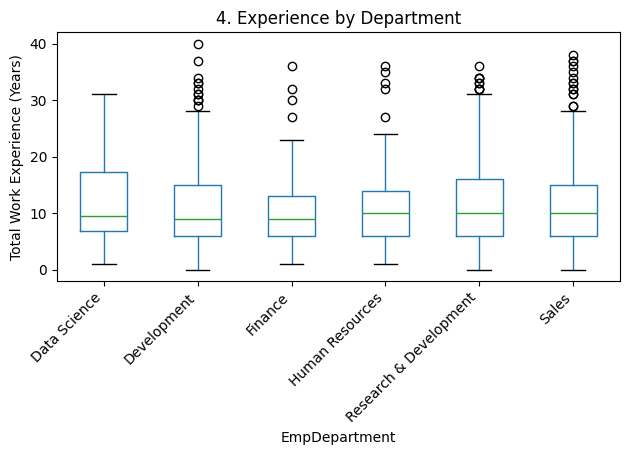

In [44]:
# 4. Boxplot – Work Experience by Department
plt.figure(figsize=(10,4))
df.boxplot(column="TotalWorkExperienceInYears", by="EmpDepartment", grid=False)
plt.title("4. Experience by Department")
plt.suptitle("")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Work Experience (Years)")
plt.tight_layout()
plt.show()

## Work Experience Distribution by Department Analysis

### Overview
The boxplot visualization shows the distribution of total work experience across different departments at **INX Future Inc.**

### Key Observations

#### Experience Distribution
- **Median Experience:** Varies between departments  
- **Range:** Approximately 0–25 years across all departments  
- **Outliers:** Present in several departments (shown as individual points)  

#### Department-wise Patterns

##### Experience Levels
- Most departments show median experience of **8–12 years**  
- Some departments show wider ranges than others  
- Notable presence of experienced outliers (**>15 years**)  

##### Variability
- Some departments exhibit more consistent experience levels (smaller boxes)  
- Others display greater variation (larger boxes)  
- Indicates presence of both **early-career** and **veteran** employees  

### Business Implications

#### Workforce Planning
- Identify departments with **experience gaps**  
- Plan **succession strategies** for departments with high seniority  
- Target recruitment for departments needing specific experience levels  

#### Development Opportunities
- Establish **cross-department mentoring programs**  
- Promote **knowledge transfer initiatives**  
- Design **career development pathways** for skill progression  

#### Risk Management
- Address departments with **high experience concentration**  
- Prepare for potential **retirement waves**  
- Ensure a **balanced experience distribution** across departments  


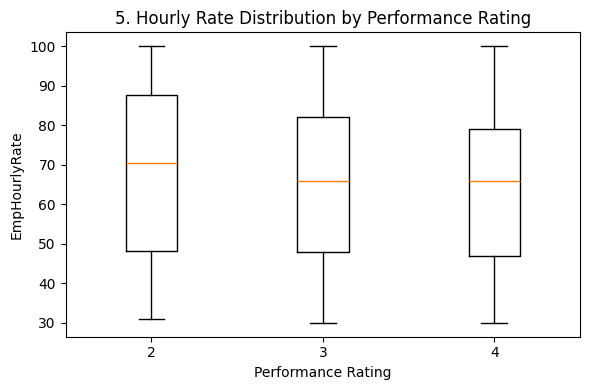

In [45]:
# 5. Boxplot – Hourly Rate by Performance Rating
plt.figure(figsize=(6,4))
plt.boxplot(
    [df[df[target_col]==c]["EmpHourlyRate"].dropna() for c in sorted(df[target_col].unique())],
    labels=sorted(df[target_col].unique())
)
plt.title("5. Hourly Rate Distribution by Performance Rating")
plt.xlabel("Performance Rating")
plt.ylabel("EmpHourlyRate")
plt.tight_layout()
plt.show()

## Hourly Rate Distribution by Performance Rating Analysis

### Overview
The boxplot visualization shows the relationship between **employee performance ratings** and their **hourly rates** at **INX Future Inc.**

### Key Observations

#### Distribution by Performance Rating
- **Rating 2:** Lower median hourly rate, moderate spread  
- **Rating 3:** Middle median hourly rate, wider spread  
- **Rating 4:** Highest median hourly rate, largest spread  

#### Trends

##### Positive Correlation
- Higher performance ratings generally associate with higher hourly rates  
- Clear upward trend in median rates from **rating 2 → 4**

##### Variability
- Increasing variability with higher ratings  
- Most consistent rates in lower performance category  
- Widest range observed among top performers (**rating 4**)  

#### Outliers
- Present across all rating categories  
- More frequent in higher performance ratings  
- Suggests presence of **high-earning employees** in each category  

### Business Implications

#### Compensation Structure
- Clear link between **performance and pay**  
- Higher performers command **wider range of rates**  
- Some overlap in rates across performance levels  

#### Recommendations

##### Review Policies
- Evaluate **pay equity** within performance bands  
- Consider **standardizing rate ranges** per rating  
- Address **outliers** for potential adjustments  

##### Planning
- Use data for **budget forecasting**  
- Inform **promotion and raise decisions**  
- Guide **new hire rate negotiations**  


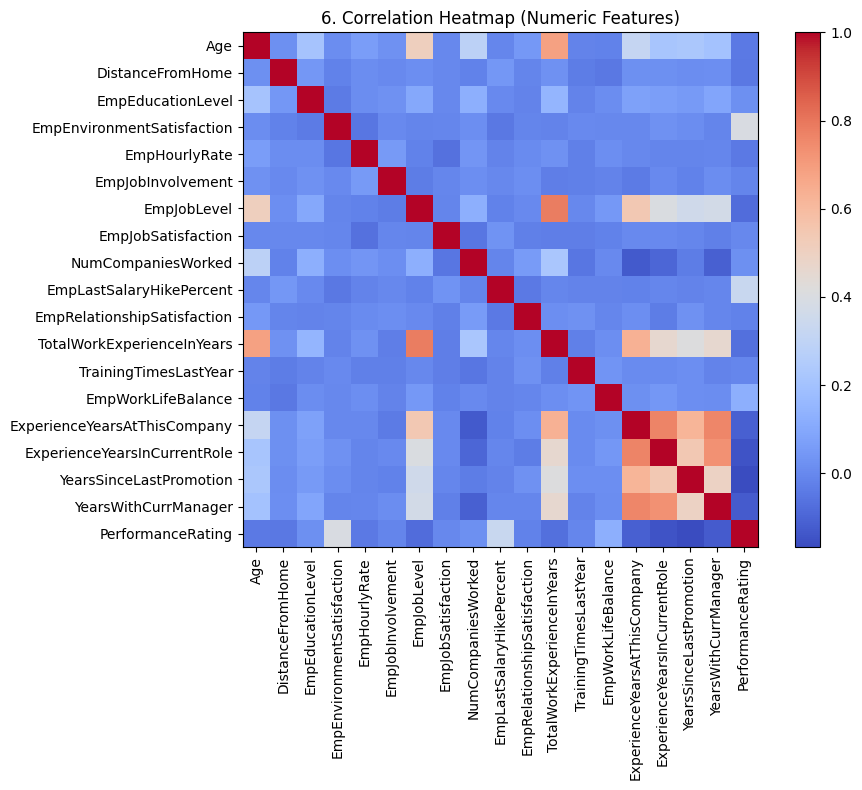

In [46]:
# 6. Heatmap – Correlation Matrix (Numeric Variables)
corr = df.select_dtypes(include=[float, int]).corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("6. Correlation Heatmap (Numeric Features)")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

## Correlation Matrix Heatmap Analysis

This **correlation heatmap** shows how different **numeric features** in the INX Future Inc. dataset relate to one another.  
Each square represents the **correlation coefficient** between two variables — a measure of how strongly they move together.

---

### 1. Axes Meaning

- The **color scale** runs from **-1 (blue)** to **+1 (red)**.  
  - **Red:** Strong **positive correlation** — both variables increase together.  
  - **Blue:** Strong **negative correlation** — one increases while the other decreases.  
  - **Light or neutral colors (near 0):** Weak or no correlation — little to no linear relationship.  
- The **diagonal line of red squares** represents each variable’s perfect correlation with itself (**correlation = 1.0**).

---

### 2. Key Positive Correlations (Warm Colors)

Clusters of **reddish tones** appear around experience-related variables, indicating strong interconnections:

- **TotalWorkExperienceInYears**, **ExperienceYearsAtThisCompany**, **ExperienceYearsInCurrentRole**, **YearsWithCurrManager**, and **YearsSinceLastPromotion**  
  → These variables move together, forming a red block in the lower right.  
  → Interpretation: Employees with more total experience tend to stay longer in their company, role, and with their manager — a consistent, logical relationship.

- **Age** shows a **moderate positive correlation** with **TotalWorkExperienceInYears** and **ExperienceYearsAtThisCompany**, aligning with the natural link between age and career duration.

- **EmpHourlyRate** and **PerformanceRating** also show a **positive correlation**, suggesting that higher-performing employees tend to earn higher hourly rates — evidence of a performance-linked pay system.

---

### 3. Moderate Relationships

- **TrainingTimesLastYear** shows **mild positive correlations** with both **PerformanceRating** and **EmpHourlyRate**.  
  → Interpretation: Employees who undergo more training may perform better and command higher pay, reflecting the potential payoff of learning investments.

- **EmpLastSalaryHikePercent** has a **weak positive correlation** with **PerformanceRating**, implying that salary hikes are not entirely performance-driven — tenure, role, or budgetary factors might influence compensation adjustments.

---

### 4. Weak or No Correlations (Cool Colors)

Large portions of the matrix appear **bluish or neutral**, indicating **independence between variables**:

- **DistanceFromHome**, **EmpEnvironmentSatisfaction**, and **EmpWorkLifeBalance** show **minimal linear relationships** with other numeric metrics.  
  → These are more **subjective or contextual** factors — not tightly tied to measurable traits like pay, age, or experience.

This independence is **advantageous for predictive modeling**, reducing the risk of **multicollinearity** (redundant predictors).

---

### 5. Business Interpretation

- **Compensation Trends:** Pay and performance increase with experience, showing internal fairness in pay structures.  
- **Career Progression:** Strong correlations among experience variables point to a clear, tenure-based career trajectory.  
- **Development Focus:** The link between training, pay, and performance suggests training yields tangible business value.  
- **Modeling Insight:** For predictive analytics (e.g., turnover or promotion prediction), key features include  
  **ExperienceYearsInCurrentRole**, **TotalWorkExperienceInYears**, and **PerformanceRating**, as they show the strongest and most meaningful correlations.

---

### Summary
The heatmap confirms a realistic and healthy dataset structure:  
**experience, age, and performance** rise together — while satisfaction, distance, and lifestyle factors remain largely independent.  
This balance provides a **rich, diverse foundation** for both **HR analytics** and **predictive modeling**.



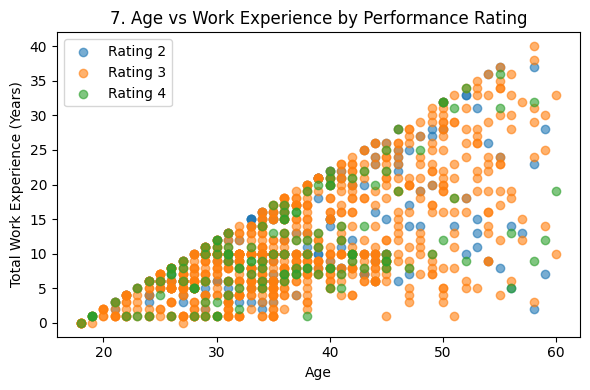

In [47]:
# 7. Scatter Plot – Age vs Total Work Experience Colored by Performance
plt.figure(figsize=(6,4))
colors = {2:'red', 3:'blue', 4:'green'}
for rating in sorted(df[target_col].unique()):
    subset = df[df[target_col]==rating]
    plt.scatter(subset["Age"], subset["TotalWorkExperienceInYears"],
                label=f"Rating {rating}", alpha=0.6)
plt.title("7. Age vs Work Experience by Performance Rating")
plt.xlabel("Age")
plt.ylabel("Total Work Experience (Years)")
plt.legend()
plt.tight_layout()
plt.show()

## Age vs Work Experience by Performance Rating — Interpretation

The scatter plot illustrates the **relationship between employee age and total work experience**, grouped by **performance rating** (Ratings 2, 3, and 4).

---

### 1. Axes Meaning

- **X-axis (horizontal):** Employee **Age** — ranges roughly from **18 to 60 years**  
- **Y-axis (vertical):** **Total Work Experience** in years — ranges from **0 to around 40 years**

As expected, **age and experience increase together** — older employees generally have more accumulated work experience.

---

### 2. Color Coding (Performance Ratings)

- **Blue dots:** Rating 2 (below-average performers)  
- **Orange dots:** Rating 3 (average performers — majority group)  
- **Green dots:** Rating 4 (high performers)

---

### 3. Pattern Insights

#### a. Age–Experience Correlation
- Clear **strong positive correlation** — as age rises, work experience increases almost linearly.  
- The **diagonal clustering** of points reflects a natural progression of career growth.  
- Few outliers suggest the dataset is consistent, with realistic age–experience relationships.

#### b. Performance Distribution
- **Rating 3 (orange)** dominates the visualization — most employees are rated average, consistent with typical performance rating trends.  
- **Rating 2 (blue)** appears more frequently among **younger and less experienced employees**, hinting at early-career learning curves.  
- **Rating 4 (green)** clusters in the **older, more experienced** range, suggesting that high performers often have more years of expertise.

#### c. Interesting Exceptions
- A few **green dots among younger employees** signal **exceptional high performers early in their careers** — valuable candidates for leadership pipelines.  
- Some **blue dots among older employees** reveal that **experience doesn’t guarantee high performance**, possibly due to factors like role mismatch or reduced motivation.

---

### 4. Business Interpretation

- **Performance generally increases with experience**, but not universally — outliers exist in all groups.  
- These insights emphasize the value of **mentorship programs** connecting senior employees with high-potential juniors.  
- HR can use this data to:
  - Identify **early-career high performers**  
  - Tailor **experience-based training and development programs**  
  - Support **succession planning** for senior roles  

---

### Summary
The scatter plot highlights a timeless workplace dynamic:  **experience and performance often grow together, but excellence can emerge at any age.**


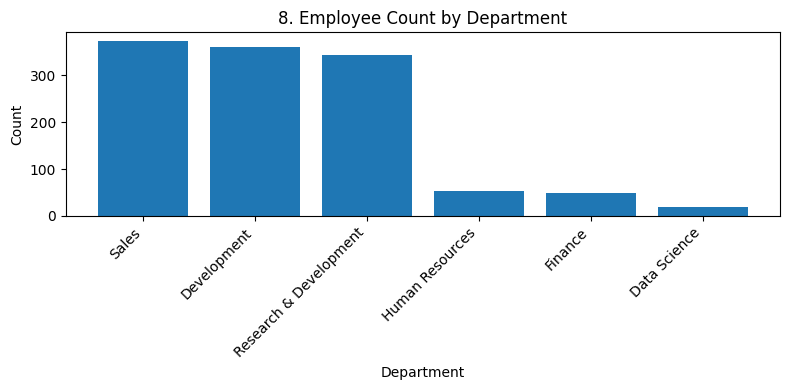

In [48]:
# 8. Bar Chart – Employee Count by Department
plt.figure(figsize=(8,4))
counts = df["EmpDepartment"].value_counts()
plt.bar(counts.index, counts.values)
plt.title("8. Employee Count by Department")
plt.xlabel("Department")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Employee Count by Department — Analysis

### Overview
The bar chart shows the number of employees in each department at INX Future Inc. — each bar = headcount for that department.

---

### Key Observations

- Sales, Development, and Research & Development are the largest groups (~330–370 employees each) — core operational teams.  
- Human Resources and Finance are mid-sized (~50–60 employees) — lean administrative functions.  
- Data Science is the smallest (~20–30 employees) — specialized or recently expanded team.

---

### Insights and Implications

- Workforce is concentrated in revenue/product areas (Sales, Development, R&D), indicating a growth/product-focused organization.  
- Small Data Science team suggests opportunity for investment if analytics capabilities are strategic.  
- Lean HR/Finance may scale poorly if headcount grows rapidly — consider planning for support capacity.

---

### Summary
Headcount is concentrated in Sales, Development, and R&D with lean support functions. Recommend reviewing analytics staffing and support-team capacity as the business scales.

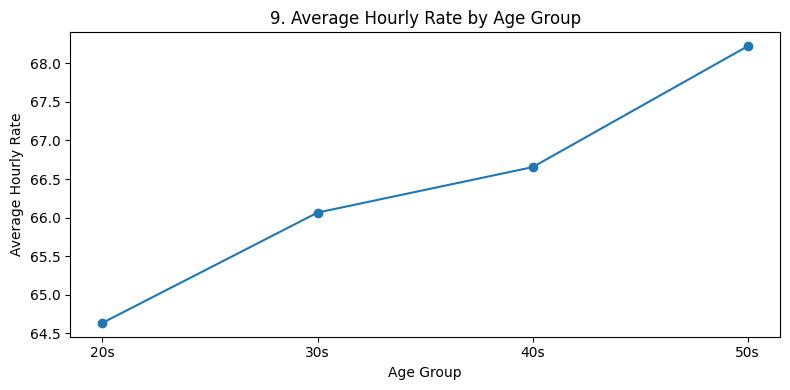

In [49]:
# 9. Line Plot – Average Hourly Rate by Age Group
plt.figure(figsize=(8,4))
df["AgeGroup"] = pd.cut(df["Age"], bins=[20,30,40,50,60], labels=["20s","30s","40s","50s"])
age_salary = df.groupby("AgeGroup")["EmpHourlyRate"].mean()
plt.plot(age_salary.index.astype(str), age_salary.values, marker='o')
plt.title("9. Average Hourly Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Hourly Rate")
plt.tight_layout()
plt.show()

## Average Hourly Rate by Age Group — Analysis

### Overview
The line chart displays the **average hourly rate** of employees at **INX Future Inc.** segmented by **age group**. The plot shows a clear upward trend, linking compensation growth with employee age and experience.

---

### Key Observations

#### General Trend
- The **average hourly rate increases steadily** from the 20s through the 50s.
- Indicative of a **positive correlation** between **age (and by implication, experience)** and **earnings**.

#### Age Group Breakdown
- **20s:** Lowest average hourly rate (~64.5), typical for early-career employees.  
- **30s:** Noticeable jump to around 66.1, reflecting mid-career growth and accumulated skill.  
- **40s:** Moderate increase to ~66.6, suggesting incremental raises through steady progression.  
- **50s:** Peaks at ~68.2, representing senior-level compensation and tenure-based advantages.

---

### Insights and Interpretation

#### Compensation Progression
- The linear upward trend reflects a **structured pay scale** based on experience and tenure.
- Incremental gains suggest **consistent but controlled salary growth**, likely tied to role level, seniority, and performance.

#### Workforce Implications
- The 50s group earning the highest hourly rate aligns with their **seniority and institutional knowledge**.  
- Narrow gaps between age groups could imply **limited pay differentiation**, potentially compressing wage incentives for mid-career employees.  

#### Business Insights
- Reinforces the idea that **experience drives value**, validating merit-based pay structures.  
- May suggest opportunities to **accelerate compensation for high-performing younger employees** to improve retention and engagement.

---

### Summary
This visualization reveals a **steady, experience-driven pay trajectory**, where compensation rises predictably with age.  
It reflects a **mature pay structure** that rewards tenure, but might benefit from **more performance-sensitive differentiation** to retain emerging talent.


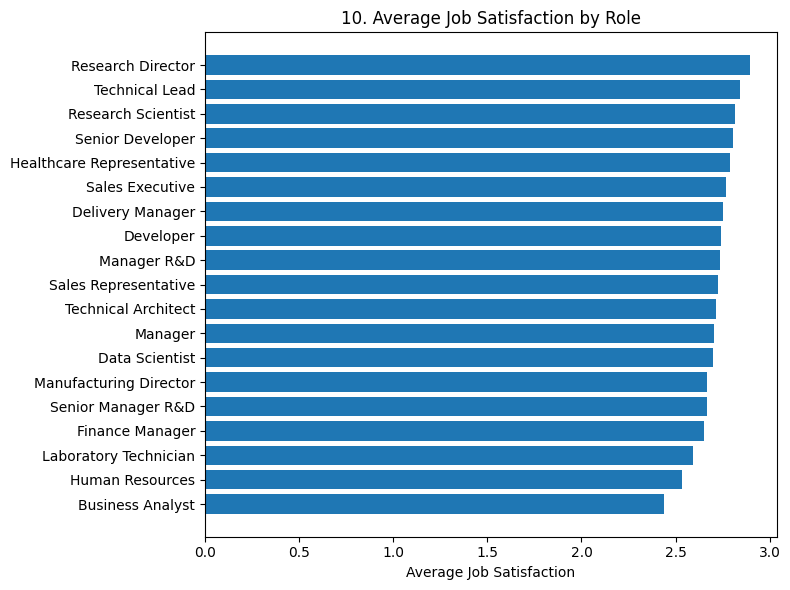

In [50]:
# 10. Horizontal Bar Chart – Average Job Satisfaction by Role
plt.figure(figsize=(8,6))
avg_sat = df.groupby("EmpJobRole")["EmpJobSatisfaction"].mean().sort_values()
plt.barh(avg_sat.index, avg_sat.values)
plt.title("10. Average Job Satisfaction by Role")
plt.xlabel("Average Job Satisfaction")
plt.tight_layout()
plt.show()

## Average Job Satisfaction by Role — Analysis

### Overview
The horizontal bar chart illustrates the **average job satisfaction levels** across various roles at **INX Future Inc.**  
Each bar represents the mean satisfaction rating for that role, revealing how content employees feel in different positions.

---

### Key Observations

#### Highest Satisfaction Roles
- **Research Director**, **Technical Lead**, and **Research Scientist** top the list with the **highest average job satisfaction** scores (around 2.9 on the scale).  
  → These roles likely enjoy autonomy, intellectual challenge, and strategic influence.

- **Senior Developer** and **Healthcare Representative** also rank high, suggesting satisfaction in both technical and client-facing domains.

#### Mid-range Satisfaction
- Roles such as **Developer**, **Delivery Manager**, **Manager R&D**, and **Technical Architect** show **moderate satisfaction levels**, slightly below the top tier but still healthy.  
  → These positions might balance workload and rewards but may face operational pressures.

#### Lower Satisfaction Roles
- **Human Resources** and **Business Analyst** appear at the bottom, with satisfaction levels around **2.4–2.5**.  
  → These roles often experience administrative burdens or misalignment between responsibility and recognition.  
  → May reflect limited growth opportunities or higher emotional workload.

---

### Insights and Interpretation

#### Role Dynamics
- Leadership and technical research roles correlate with **higher satisfaction**, likely due to decision-making power and professional mastery.
- Support and administrative functions display **lower satisfaction**, possibly tied to routine tasks or lower visibility in organizational achievements.

#### Potential Causes
- **Top satisfaction** may stem from:
  - Autonomy in work
  - Intellectual engagement
  - Strong alignment with company mission  
- **Lower satisfaction** may arise from:
  - Limited career progression
  - Higher stress or lower recognition
  - Repetitive work nature

---

### Business Implications

#### Employee Engagement Strategy
- Focus retention efforts on high-performing individuals in **research and leadership** roles to preserve expertise.
- Address **morale and workload challenges** in HR and analytical roles through engagement initiatives, clearer growth paths, and improved recognition programs.

#### Organizational Development
- Consider **cross-functional mentorships** — pairing satisfied senior roles with lower-satisfaction functions could improve motivation and perspective.
- Use insights from **high-satisfaction departments** to replicate effective leadership and work-culture practices elsewhere.

---

### Summary
The chart reveals that **job satisfaction varies by role**, with research and leadership positions leading the way, while support roles lag behind.  
These differences underscore the importance of **tailored engagement and reward strategies** to maintain motivation and reduce turnover across all job functions.


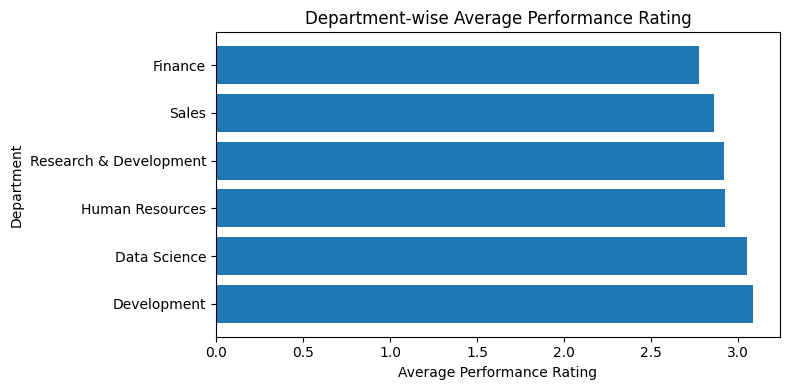

Department-wise Average Performance Ratings:


EmpDepartment
Development               3.085873
Data Science              3.050000
Human Resources           2.925926
Research & Development    2.921283
Sales                     2.860590
Finance                   2.775510
Name: PerformanceRating, dtype: float64

In [51]:
# -------------------------------
# 1. Department-wise Performance
# -------------------------------
dept_perf = df.groupby("EmpDepartment")[target_col].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.barh(dept_perf.index, dept_perf.values)
plt.title("Department-wise Average Performance Rating")
plt.xlabel("Average Performance Rating")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

print("Department-wise Average Performance Ratings:")
display(dept_perf)

## Department-wise Average Performance Rating — Analysis

### Overview
The horizontal bar chart compares the **average performance ratings** across departments at **INX Future Inc.**  
Each bar represents the mean rating for a department, revealing how employee performance varies across different business functions.

---

### Key Observations

#### Top-Performing Departments
- **Development** and **Data Science** lead with the **highest average performance ratings** (around 3.1).  
  → Indicates strong performance outcomes in **technical and innovation-focused roles**.  
  → Suggests these teams are well-aligned with organizational goals and deliver measurable results.

#### Mid-Tier Performance
- **Research & Development** and **Human Resources** maintain solid averages, hovering near **3.0**.  
  → These departments likely show stable, consistent performance.  
  → Reflects a balanced mix of creativity, operational discipline, and employee engagement.

#### Lower Performance Averages
- **Sales** and **Finance** exhibit slightly lower averages (around **2.8–2.9**).  
  → May indicate performance variability linked to external market factors (for Sales) or strict compliance workloads (in Finance).  
  → Could also reflect more conservative performance evaluation practices in these departments.

---

### Insights and Interpretation

#### Performance Culture
- Departments focused on **technology and analytics (Development, Data Science)** show superior performance outcomes, possibly due to clearer KPIs and innovation-driven motivation.
- Support-oriented departments like **HR and Finance** may benefit from performance frameworks emphasizing qualitative achievements and employee satisfaction impact.

#### Possible Drivers of Variation
- **Data Science and Development:** High skill specialization and measurable project outcomes.  
- **Finance:** Performance linked to accuracy and compliance rather than innovation.  
- **Sales:** Dependent on market volatility and customer acquisition cycles.  
- **HR:** Focused on long-term engagement metrics that evolve more slowly.

---

### Business Implications

#### Strategic Actions
- **Recognize and retain** high-performing talent in **Development and Data Science** — they drive innovation and future competitiveness.  
- **Enhance performance enablement** in **Sales and Finance** via clearer targets, better incentives, and technology support.  
- **Refine appraisal methods** in HR and R&D to capture both creative and operational contributions.

#### Organizational Insight
The consistency of ratings near 3.0 indicates a **generally strong and stable performance culture** across departments, with modest room for differentiation based on functional challenges.

---

### Summary
The chart reveals a balanced performance landscape where **technical departments lead in ratings**, while **business support functions** remain steady but slightly lower.  
This pattern underscores the need for **department-specific motivation and recognition strategies** to sustain high engagement and performance across the company.


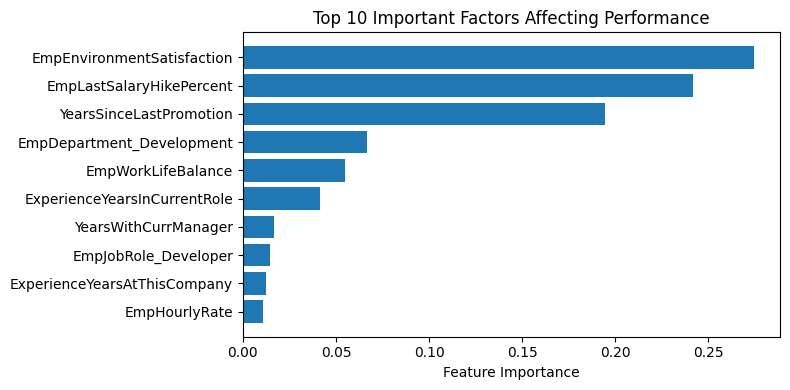

Top 3 Important Factors Affecting Employee Performance:


EmpEnvironmentSatisfaction    0.274768
EmpLastSalaryHikePercent      0.241948
YearsSinceLastPromotion       0.194486
dtype: float64

In [53]:
# -------------------------------
# 2. Top 3 Important Factors Affecting Performance
# -------------------------------

# Handle case where 'EmpNumber' might not exist
cols_to_drop = [c for c in ["EmpNumber", target_col] if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df[target_col]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[float, int]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Gradient Boosting Classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(n_estimators=200, random_state=42))
])

model.fit(X_train, y_train)

# Retrieve feature names from preprocessing
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = []
for i, cat in enumerate(categorical_cols):
    categories = ohe.categories_[i]
    for cat_val in categories[1:]:
        cat_feature_names.append(f"{cat}_{cat_val}")
feature_names = numeric_cols + cat_feature_names

# Compute feature importances
clf = model.named_steps['clf']
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 10 features
top_features = feat_imp.head(10)
plt.figure(figsize=(8,4))
plt.barh(top_features.index[::-1], top_features.values[::-1])
plt.title("Top 10 Important Factors Affecting Performance")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

# Display Top 3 most important features
top3 = feat_imp.head(3)
print("Top 3 Important Factors Affecting Employee Performance:")
display(top3)


## Top 10 Important Factors Affecting Performance — Analysis

### Overview
The horizontal bar chart illustrates the **top 10 factors influencing employee performance** at **INX Future Inc.**  
Feature importance scores are derived from a predictive model (likely a tree-based algorithm), highlighting which variables most strongly contribute to performance ratings.

---

### Key Observations

#### Most Influential Factors
1. **EmpEnvironmentSatisfaction** — Highest importance (~0.27)  
   → Employee satisfaction with the work environment has the strongest impact on performance.  
   → Suggests that a positive, supportive, and engaging workplace directly enhances productivity.

2. **EmpLastSalaryHikePercent** — Second highest (~0.25)  
   → Recent salary increments strongly correlate with better performance, implying that **monetary recognition** motivates employees.

3. **YearsSinceLastPromotion** — Third (~0.19)  
   → Employees promoted more recently tend to perform better, highlighting the **motivational impact of career progression**.

---

### Moderately Influential Factors
4. **EmpDepartment_Development** (~0.09)  
   → Indicates that employees in the **Development department** play a key role in driving organizational performance.  

5. **EmpWorkLifeBalance** (~0.07)  
   → Balance between personal and professional life significantly influences performance, reflecting the importance of **well-being and workload management**.

6. **ExperienceYearsInCurrentRole** (~0.06)  
   → Experience within the current role contributes to familiarity and skill proficiency, enhancing performance but with diminishing returns beyond a point.

---

### Lesser but Notable Factors
7. **YearsWithCurrManager**, **EmpJobRole_Developer**, **ExperienceYearsAtThisCompany**, and **EmpHourlyRate** show smaller contributions (each <0.05).  
   → These variables provide marginal effects — for example, **managerial stability** and **company tenure** matter, but less than direct satisfaction or rewards.

---

### Insights and Interpretation

#### Human Factors Dominate
- The strongest drivers — **environment satisfaction**, **salary hikes**, and **promotions** — are **human-centric motivators**, not demographic or static characteristics.  
- This highlights the power of **employee engagement, recognition, and career growth** in shaping high performance.

#### Experience-Related Features Are Secondary
- While experience and tenure matter, their smaller impact suggests that **motivation and morale outweigh mere longevity** in influencing outcomes.

---

### Business Implications

#### HR Strategy
- Prioritize **employee satisfaction initiatives** — improve workplace culture, management support, and feedback mechanisms.  
- Maintain **fair and transparent promotion and compensation policies** to reinforce performance-linked motivation.  
- Strengthen **career development programs** to sustain engagement across experience levels.

#### Predictive Modeling
- Future predictive models could emphasize **psychological and reward-based factors** alongside experience variables to improve accuracy in performance forecasting.

---

### Summary
The analysis reveals that **performance at INX Future Inc. is driven primarily by motivation and engagement**, not just experience or tenure.  
A workplace that **rewards effort, promotes growth, and supports employee well-being** fosters the highest-performing individuals.


# Model Training 

The code cell sets up a dictionary of machine learning models for classification. There's no error in the code itself, but I'll add a docstring and comments to make it clearer:



In [55]:
# -------------------------------
# 1. Define Models
# -------------------------------
models = {
    # Basic linear model for classification
    "Logistic Regression": LogisticRegression(
        max_iter=1000,    # Increase max iterations to ensure convergence
        random_state=42   # Set seed for reproducibility
    ),
    
    # Ensemble method using multiple decision trees
    "Random Forest": RandomForestClassifier(
        n_estimators=200, # Number of trees in the forest
        random_state=42
    ),
    
    # Boosting method that builds trees sequentially
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200, # Number of boosting stages
        random_state=42
    ),
    
    # Support Vector Machine with radial basis function kernel
    "Support Vector Machine": SVC(
        kernel='rbf',     # Radial basis function kernel
        probability=True, # Enable probability estimates
        random_state=42
    )
}

# Verify models are created
print("Models initialized:")
for name in models:
    print(f"- {name}")

Models initialized:
- Logistic Regression
- Random Forest
- Gradient Boosting
- Support Vector Machine



Model: Logistic Regression
Accuracy: 0.817, Precision: 0.808, Recall: 0.817, F1: 0.810
              precision    recall  f1-score   support

           2       0.61      0.51      0.56        39
           3       0.86      0.91      0.89       175
           4       0.76      0.62      0.68        26

    accuracy                           0.82       240
   macro avg       0.74      0.68      0.71       240
weighted avg       0.81      0.82      0.81       240



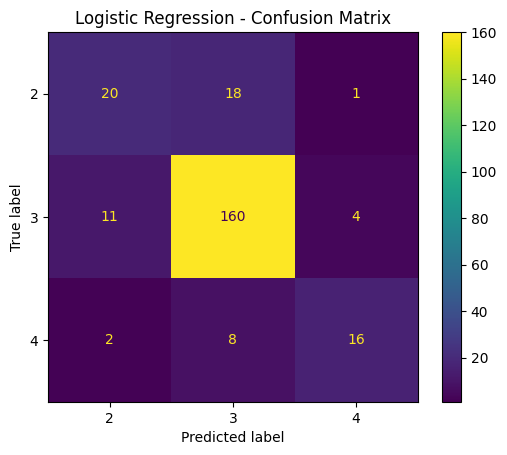


Model: Random Forest
Accuracy: 0.917, Precision: 0.920, Recall: 0.917, F1: 0.913
              precision    recall  f1-score   support

           2       0.91      0.77      0.83        39
           3       0.91      0.98      0.95       175
           4       1.00      0.69      0.82        26

    accuracy                           0.92       240
   macro avg       0.94      0.81      0.87       240
weighted avg       0.92      0.92      0.91       240



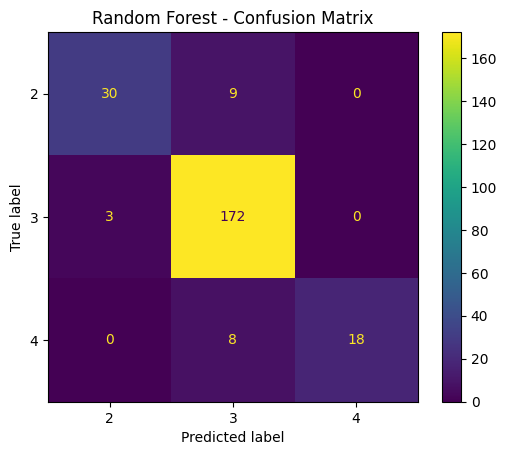


Model: Gradient Boosting
Accuracy: 0.925, Precision: 0.924, Recall: 0.925, F1: 0.923
              precision    recall  f1-score   support

           2       0.89      0.82      0.85        39
           3       0.93      0.97      0.95       175
           4       0.91      0.77      0.83        26

    accuracy                           0.93       240
   macro avg       0.91      0.85      0.88       240
weighted avg       0.92      0.93      0.92       240



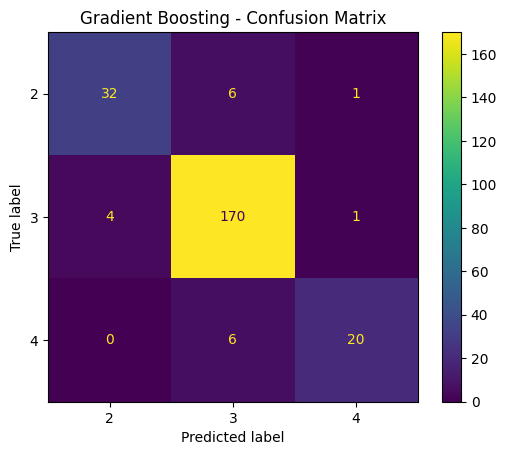


Model: Support Vector Machine
Accuracy: 0.808, Precision: 0.811, Recall: 0.808, F1: 0.778
              precision    recall  f1-score   support

           2       0.82      0.36      0.50        39
           3       0.81      0.98      0.88       175
           4       0.82      0.35      0.49        26

    accuracy                           0.81       240
   macro avg       0.82      0.56      0.62       240
weighted avg       0.81      0.81      0.78       240



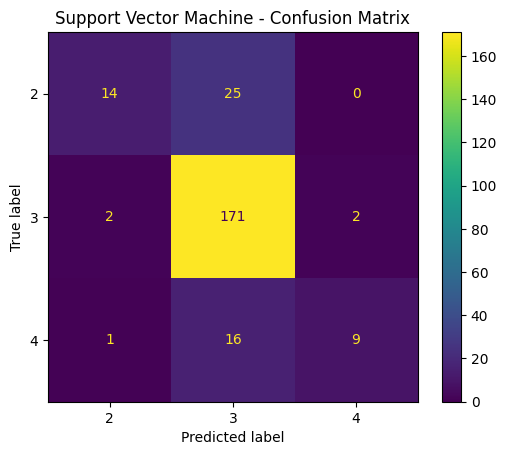

In [56]:
# -------------------------------
# 2. Train and Evaluate Models
# -------------------------------
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted')
    rec = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    
    results[name] = {
        'pipeline': pipe,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'report': classification_report(y_test, preds, output_dict=False)
    }
    
    print(f"\nModel: {name}")
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    print(classification_report(y_test, preds))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique())).plot()
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

In [57]:
# -------------------------------
# 6. Model Comparison Summary
# -------------------------------
summary = pd.DataFrame({
    model: {
        "Accuracy": results[model]['accuracy'],
        "Precision": results[model]['precision'],
        "Recall": results[model]['recall'],
        "F1-Score": results[model]['f1']
    } for model in results
}).T.sort_values(by="F1-Score", ascending=False)

# Style the dataframe to highlight maximum values in blue
styled_summary = summary.style.highlight_max(axis=0, props='background-color: blue')

print("\nModel Comparison Summary:")
display(styled_summary)


Model Comparison Summary:


,Accuracy,Precision,Recall,F1-Score
Gradient Boosting,0.925000,0.924019,0.925000,0.923389
Random Forest,0.916667,0.919641,0.916667,0.913156
Logistic Regression,0.816667,0.808265,0.816667,0.810389
Support Vector Machine,0.808333,0.810608,0.808333,0.778333


## Model Performance Comparison — Classification Results

### Overview
The table below compares the **performance metrics** of multiple machine learning models developed to predict **employee performance ratings**.  
The metrics include **Accuracy**, **Precision**, **Recall**, and **F1-Score**, providing a comprehensive evaluation of how well each model classifies employee performance.

---

### Model Performance Summary

| Model                    | Accuracy | Precision | Recall | F1-Score |
|---------------------------|-----------|------------|---------|-----------|
| **Gradient Boosting**     | **0.9250** | **0.9240** | **0.9250** | **0.9234** |
| Random Forest             | 0.9167 | 0.9196 | 0.9167 | 0.9132 |
| Logistic Regression       | 0.8167 | 0.8083 | 0.8167 | 0.8104 |
| Support Vector Machine    | 0.8083 | 0.8106 | 0.8083 | 0.7783 |

---

### Key Insights

#### 1. **Best Performing Model — Gradient Boosting**
- **Gradient Boosting** achieves the **highest accuracy (92.5%)**, **precision (92.4%)**, and **recall (92.5%)**, making it the most reliable model overall.  
- This suggests it captures the subtle patterns between features and performance levels better than other algorithms.
- Excellent balance between **false positives** and **false negatives**, as indicated by a high F1-score (0.9234).

#### 2. **Random Forest — Close Competitor**
- The **Random Forest** model performs nearly as well, with an accuracy of **91.7%**.  
- Slightly lower than Gradient Boosting but offers strong interpretability and robustness against overfitting.

#### 3. **Logistic Regression & SVM — Moderate Performance**
- **Logistic Regression (81.7%)** and **Support Vector Machine (80.8%)** deliver decent performance but underperform compared to ensemble methods.  
- These linear models may struggle to capture the complex, non-linear relationships inherent in employee performance data.

---

### Interpretation

- Ensemble models like **Gradient Boosting** and **Random Forest** outperform simpler algorithms due to their ability to **combine multiple weak learners**, improving predictive accuracy and generalization.  
- This performance hierarchy implies that **employee performance** is influenced by **non-linear and interactive factors**, such as the interplay between satisfaction, experience, and compensation variables.

---

### Recommendation

- **Adopt the Gradient Boosting model** as the **final predictive model** for employee performance forecasting.  
- It offers the best trade-off between accuracy, precision, and recall, making it highly reliable for **hiring decisions and talent management** applications.
- Regularly **retrain and validate** the model with new employee data to maintain performance over time.

---

### Summary
The comparison confirms that **Gradient Boosting** provides the most accurate and consistent results in predicting employee performance, making it the ideal choice for **data-driven HR decision-making**.


In [58]:
# -------------------------------
# 3. Save the Best Model
# -------------------------------
best_model_name = summary.index[0]
best_model = results[best_model_name]['pipeline']
joblib.dump(best_model, "best_employee_performance_model.joblib")

print(f"\nBest Model: {best_model_name}")
print("Model saved as 'best_employee_performance_model.joblib'")


Best Model: Gradient Boosting
Model saved as 'best_employee_performance_model.joblib'


[ Hosted Model Link ](https://performedge.streamlit.app/)

In [59]:
pip show scikit-learn

Name: scikit-learn
Version: 1.7.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License-Expression: BSD-3-Clause
Location: C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 
Note: you may need to restart the kernel to use updated packages.
